In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

2024-05-09 05:02:41.016234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 05:02:41.016330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 05:02:41.147167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Train'
val_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Validation'
test_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Test'

In [3]:
train_data = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    file = os.listdir(folder_path)
    num_train = int(len(file))
    files_train = random.sample(file, num_train)
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2534 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [4]:
val_data = []

for folder in os.listdir(val_path):
    folder_path = os.path.join(val_path, folder)
    file = os.listdir(folder_path)
    num_train = int(len(file))
    files_val = random.sample(file, num_train)
          
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

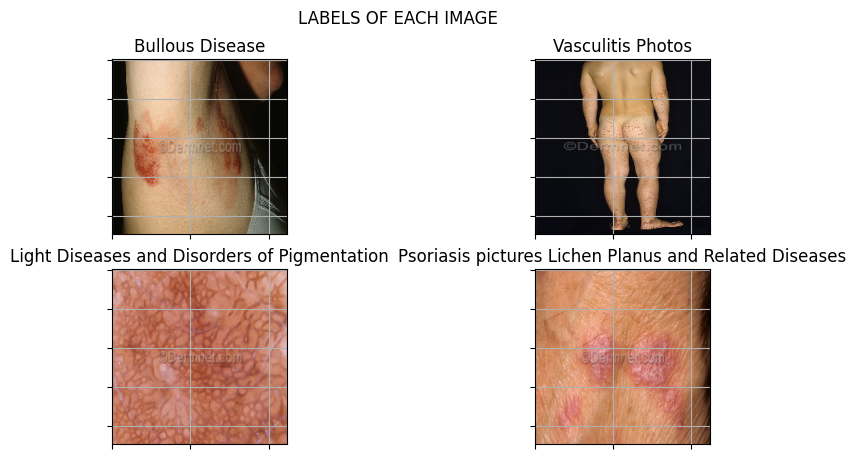

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 4), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [6]:
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

img_size = (224, 224, 3)

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

94765736/94765736 [==============================] - 0s 0us/step


In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [10]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/resnet.h5')

Epoch 1/12


I0000 00:00:1715231044.480953     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 26s 136ms/step - loss: 2.5590 - accuracy: 0.2842 - val_loss: 1.8216 - val_accuracy: 0.4723
Epoch 2/12
138/138 [==============================] - 15s 106ms/step - loss: 1.7727 - accuracy: 0.4717 - val_loss: 1.4934 - val_accuracy: 0.5472
Epoch 3/12
138/138 [==============================] - 15s 107ms/step - loss: 1.4126 - accuracy: 0.5727 - val_loss: 1.1069 - val_accuracy: 0.6777
Epoch 4/12
138/138 [==============================] - 15s 110ms/step - loss: 1.1082 - accuracy: 0.6639 - val_loss: 0.8471 - val_accuracy: 0.7616
Epoch 5/12
138/138 [==============================] - 15s 111ms/step - loss: 0.8454 - accuracy: 0.7398 - val_loss: 0.6622 - val_accuracy: 0.8291
Epoch 6/12
138/138 [==============================] - 16s 113ms/step - loss: 0.6356 - accuracy: 0.8148 - val_loss: 0.5801 - val_accuracy: 0.8501
Epoch 7/12
138/138 [==============================] - 15s 112ms/step - loss: 0.4923 - accuracy: 0.8539 - val_loss: 0.4489 - val_accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


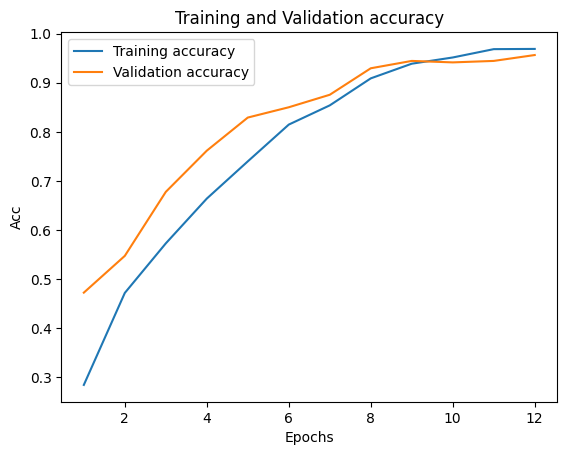

In [11]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy',)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

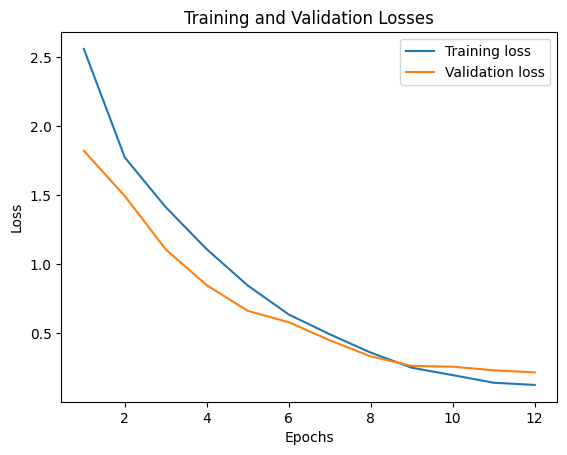

In [12]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss' )
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [13]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/resnet.h5') 
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img])) 

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 24ms/step


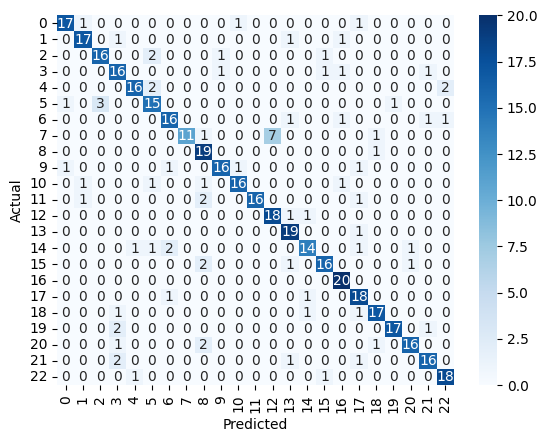

0.8260869565217391


In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(accuracy_score(real_label,predicted_class))

In [15]:
from sklearn.metrics import classification_report
print(classification_report(real_label, predicted_class))

                                                                    precision    recall  f1-score   support

                                                  Acne and Rosacea       0.89      0.85      0.87        20
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.85      0.85      0.85        20
                                                 Atopic Dermatitis       0.84      0.80      0.82        20
                                                   Bullous Disease       0.70      0.80      0.74        20
                Cellulitis Impetigo and other Bacterial Infections       0.89      0.80      0.84        20
                                                            Eczema       0.71      0.75      0.73        20
                                      Exanthems and Drug Eruptions       0.80      0.80      0.80        20
                 Hair Loss Photos Alopecia and other Hair Diseases       1.00      0.55      0.71        20
                           

In [17]:
# Load the model
model_path = '/kaggle/working/resnet.h5'
model = load_model(model_path)

# Function for single image prediction
def predict_single_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(np.array([img]))

    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    
    return predicted_class_index

# Example usage
image_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Test/Eczema/Eczema_ (114).jpg'
predicted_class_index = predict_single_image(image_path, model)
predicted_class_label = le.classes_[predicted_class_index]
print("Predicted class index:", predicted_class_index)
print("Predicted class label:", predicted_class_label)

1/1 [==============================] - 1s 1s/step
Predicted class index: 5
Predicted class label: Eczema


Training Process:

The training log shows progressive improvement in both training and validation accuracy over 12 epochs:

Epoch 1: Training accuracy = 0.2842, Validation accuracy = 0.4723

Epoch 6: Training accuracy = 0.8148, Validation accuracy = 0.8501

Epoch 12: Training accuracy = 0.9690, Validation accuracy = 0.9565

Evaluation Metrics:

A confusion matrix and an overall accuracy score were calculated. The reported accuracy for the test dataset was 83%.
A detailed breakdown of performance for each class (e.g., precision, recall, F1-score) was provided. Macro average accuracy was also 83%.

Visualization:

Accuracy trends were plotted for training and validation, showing convergence and improvements over epochs.
These results highlight that the model achieved high accuracy, especially in the later epochs, indicating successful training and good generalization to the validation data. ​